In [23]:
import torch
import torch.nn as nn
import numpy as np 
import numpy.random as npr
from matplotlib import pyplot as plt

from diffusers import DDIMScheduler, DDPMScheduler
from torch.utils.data import DataLoader
import torch.optim as optim

In [ ]:
class SinusoidalEmbedding(nn.Module):
    def __init__(self, size: int, scale: float = 1.0):
        super().__init__()
        self.size = size
        self.scale = scale

    def forward(self, x: torch.Tensor):
        x = x * self.scale
        half_size = self.size // 2
        emb = torch.log(torch.Tensor([10000.0])) / (half_size - 1)
        emb = torch.exp(-emb * torch.arange(half_size))
        emb = x.unsqueeze(-1) * emb.unsqueeze(0)
        emb = torch.cat((torch.sin(emb), torch.cos(emb)), dim=-1)
        return emb

    def __len__(self):
        return self.size
    
class denoising(nn.Module):
    
    def __init__(self) -> None:
        super().__init__()
        self.t_embedding = SinusoidalEmbedding(size=128, scale=1.0)
        # self.x_embedding = nn.Linear(2, 128)
        self.x_embeddings_1 = SinusoidalEmbedding(size=64, scale=20.0)
        self.x_embeddings_2 = SinusoidalEmbedding(size=64, scale=20.0)
        
        self.network = nn.ModuleList([
            nn.Linear(256, 256),
            nn.GELU(),
             nn.Linear(256, 256),
            nn.GELU(),
            nn.Linear(256, 256),
            nn.GELU(),
            nn.Linear(256, 2)
        ])
        self.network = nn.Sequential(*self.network)
        for module in self.network.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0, std=0.05)
                nn.init.constant_(module.bias, 0)
    def forward(self, x, t) -> None:
        # x_emb = self.x_embedding(x)
        x_emb1 = self.x_embeddings_1(x[:,0])
        x_emb2 = self.x_embeddings_2(x[:,1])
        t_emb = self.t_embedding(t)
        # x = torch.concat((x_emb,t_emb), dim = -1)
        x = torch.concat((x_emb1,x_emb2,t_emb), dim = -1)
        return self.network(x)
    

net = denoising()
net(torch.Tensor([[3,3]]),torch.tensor([1]))

tensor([[-0.0037, -0.0240]], grad_fn=<AddmmBackward0>)

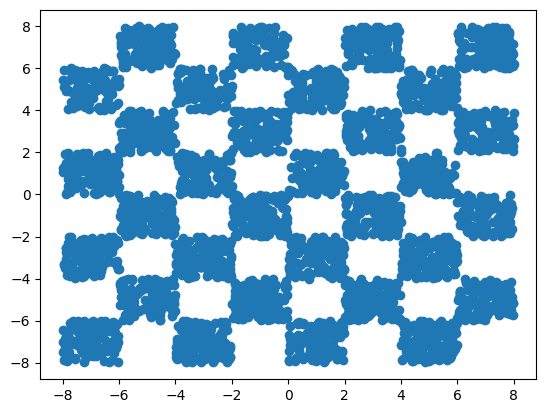

In [25]:

# Checkboard distribution pattern
def sample(num_points=1, n=4, range=[-3,3]):

    point = npr.uniform(0,1,size=(num_points,2))
    
    choice = npr.choice(np.arange(2*n*n), size = num_points)
    grid_sector_row = choice //n
    grid_sector_col = grid_sector_row%2 + 2*(choice%n)
    # print(choice)
    # print(grid_sector_row)
    # print(grid_sector_col)
    scale_x = (range[1] - range[0])/(2*n)
    scale_y = (range[1] - range[0])/(2*n)
    start_x = range[0] + (range[1] - range[0])/(2*n) * grid_sector_row
    start_y = range[0] + (range[1] - range[0])/(2*n) * grid_sector_col
    point[:, 0] = point[:, 0] * scale_x + start_x  
    point[:, 1] = point[:, 1] * scale_y + start_y  
    return point



ps = sample(num_points=4096, n=4, range=[-8,8])
plt.scatter(ps[:, 0], ps[:,1])



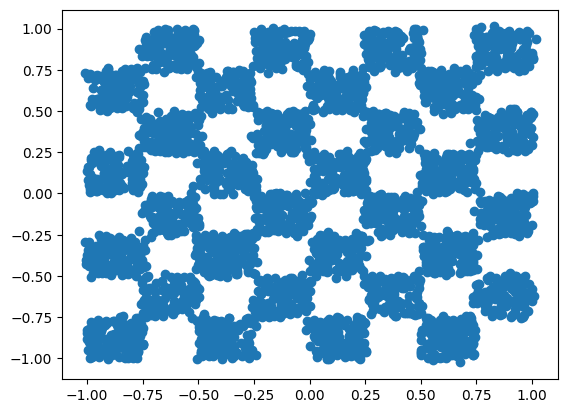

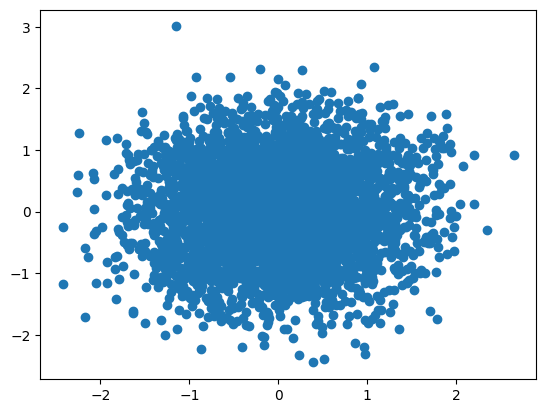

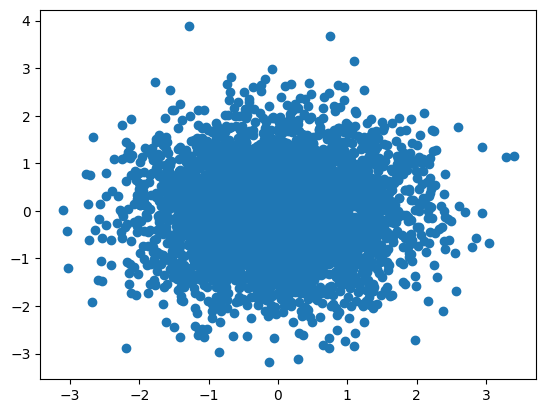

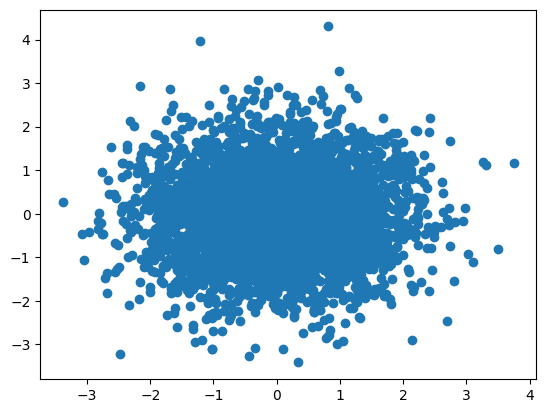

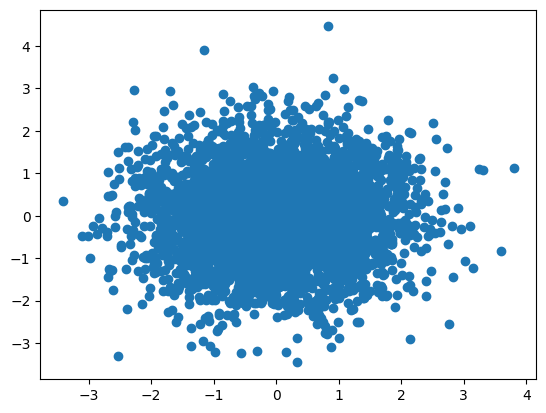

In [26]:
data = sample(num_points=4096, n=4, range=[-1,1])
data = torch.tensor(data, dtype=torch.float32)

scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="linear")
sample_noise = torch.normal(torch.zeros(data.shape), std=torch.tensor(1.0))
sample_noise2 = torch.normal(torch.zeros(data.shape), std=torch.tensor(1.0))
for t in range(0,1000,200):
    t = torch.tensor(np.array([t]*data.shape[0])).unsqueeze(1)
    noised_samples = scheduler.add_noise(data, sample_noise, t)
    
    plt.figure()
    plt.scatter(noised_samples[:,0], noised_samples[:,1])

In [27]:
# With diffusers noise scheduler
import torch.utils
import torch.utils.data




epochs = 1500
batch_size = 256
dataset = sample(num_points=4096, n=4, range=[-1,1])
noise = torch.normal(torch.zeros(dataset.shape), std=torch.tensor(1.0))
dataset = torch.utils.data.TensorDataset(torch.tensor(dataset, dtype=torch.float32))
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# Call scheduler.step() after each epoch

net = denoising()
net.train()
scaler = torch.cuda.amp.GradScaler()
scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="linear")

optimizer = optim.Adam(net.parameters(), lr=1e-3)  # Typical choice for diffusion models
# lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

def train_diffusion_step(model, samples, diffusion_steps=1000, loss_factor = 0.1):
    sampled_noise = torch.normal(torch.zeros(samples.shape), std=torch.tensor(1.0))
    time_steps = torch.randint(
        low=0,
        high=1000,  # Exclusive upper bound (1001 → 1000 max)
        size=(samples.shape[0],)
    )

    noised_samples = scheduler.add_noise(samples.clone(), sampled_noise, time_steps)
    
    pred_noise = model(noised_samples, time_steps)
    return loss_factor * (pred_noise - sampled_noise)**2

def train():
    
    for ep in range(epochs): 
        total_loss = 0.   
        for _, samples in enumerate(dataloader):
            # Clear previous gradients
            optimizer.zero_grad()
            # Compute loss from diffusion process
            loss = train_diffusion_step(net, samples[0])
            
            # Backpropagate gradients
            loss.mean().backward()
            
            # Update network parameters
            optimizer.step()
            
            total_loss += loss.mean().item()
                # Optional: Learning rate scheduling
        avg_loss = total_loss / len(dataloader)
        # lr_scheduler.step()
        print(f"Epoch {ep+1}/{epochs} | Loss: {avg_loss:.4f}")
            
train()         
        

Epoch 1/1500 | Loss: 0.0325
Epoch 2/1500 | Loss: 0.0212
Epoch 3/1500 | Loss: 0.0194
Epoch 4/1500 | Loss: 0.0206
Epoch 5/1500 | Loss: 0.0193
Epoch 6/1500 | Loss: 0.0202
Epoch 7/1500 | Loss: 0.0194
Epoch 8/1500 | Loss: 0.0196
Epoch 9/1500 | Loss: 0.0184
Epoch 10/1500 | Loss: 0.0194
Epoch 11/1500 | Loss: 0.0202
Epoch 12/1500 | Loss: 0.0188
Epoch 13/1500 | Loss: 0.0181
Epoch 14/1500 | Loss: 0.0192
Epoch 15/1500 | Loss: 0.0192
Epoch 16/1500 | Loss: 0.0184
Epoch 17/1500 | Loss: 0.0200
Epoch 18/1500 | Loss: 0.0200
Epoch 19/1500 | Loss: 0.0175
Epoch 20/1500 | Loss: 0.0191
Epoch 21/1500 | Loss: 0.0185
Epoch 22/1500 | Loss: 0.0181
Epoch 23/1500 | Loss: 0.0194
Epoch 24/1500 | Loss: 0.0195
Epoch 25/1500 | Loss: 0.0186
Epoch 26/1500 | Loss: 0.0178
Epoch 27/1500 | Loss: 0.0187
Epoch 28/1500 | Loss: 0.0197
Epoch 29/1500 | Loss: 0.0176
Epoch 30/1500 | Loss: 0.0195
Epoch 31/1500 | Loss: 0.0198
Epoch 32/1500 | Loss: 0.0193
Epoch 33/1500 | Loss: 0.0188
Epoch 34/1500 | Loss: 0.0184
Epoch 35/1500 | Loss: 0

Step 0
Step 100
Step 200
Step 300
Step 400
Step 500
Step 600
Step 700
Step 800
Step 900
Step 999


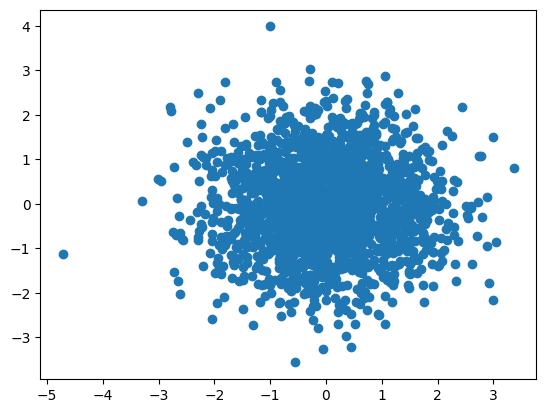

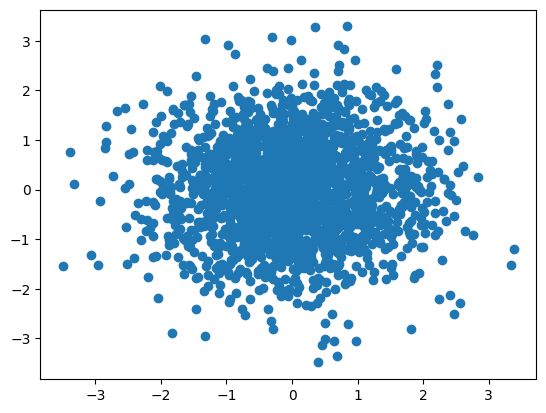

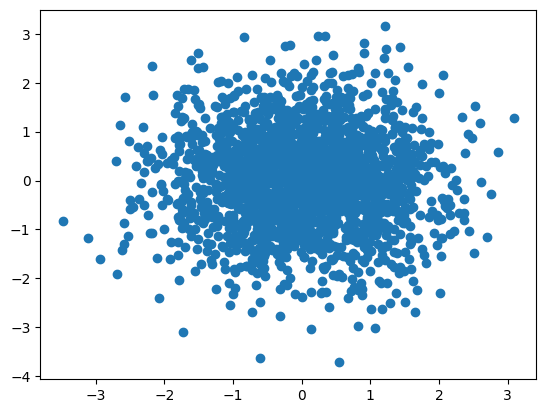

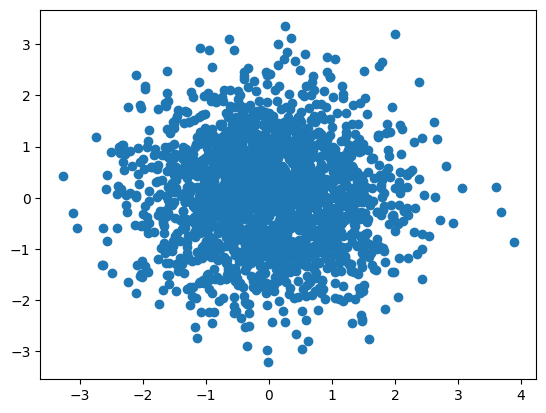

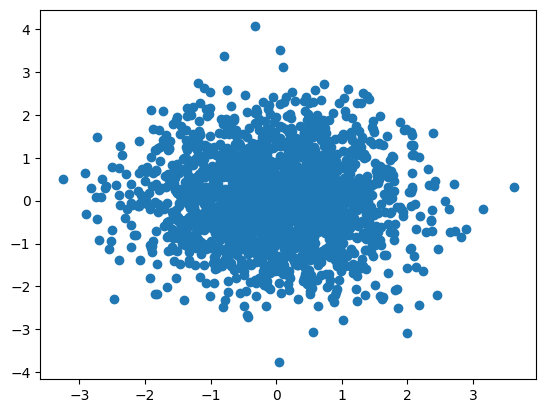

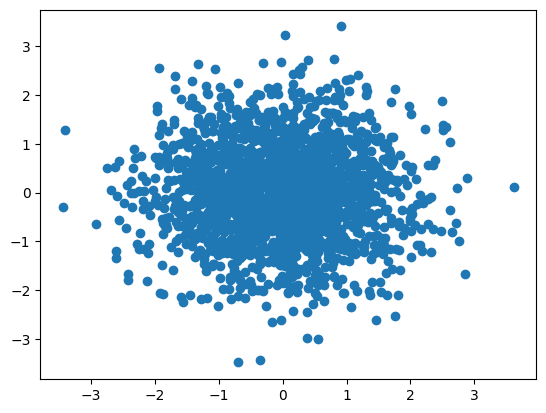

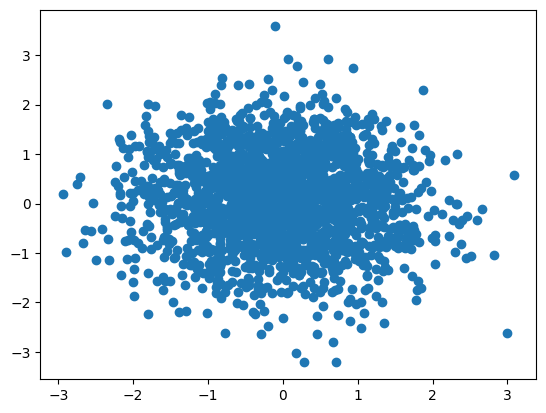

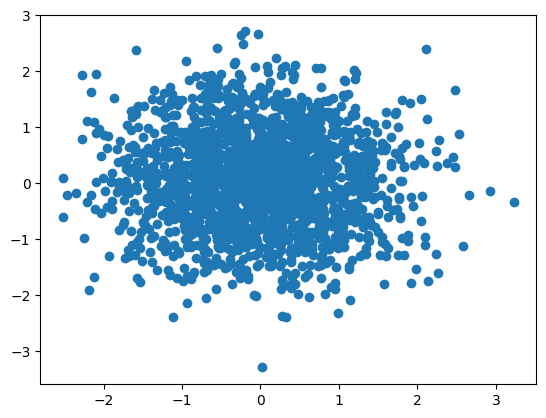

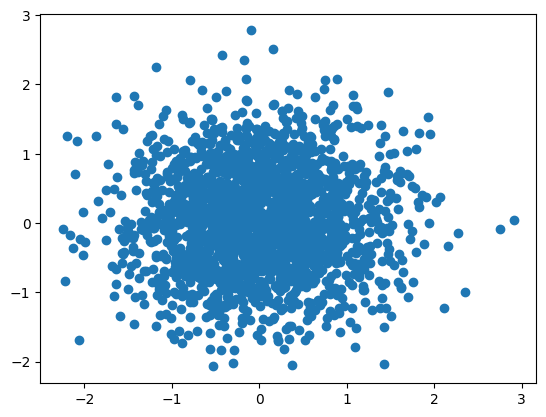

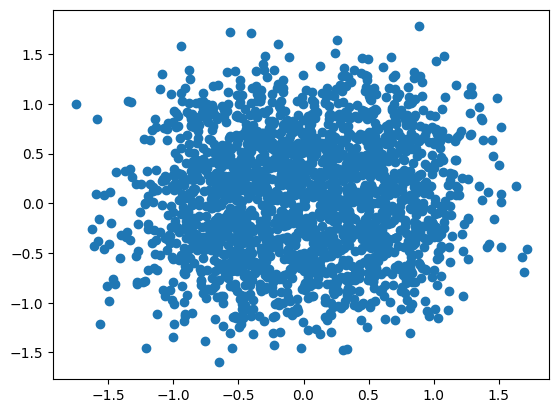

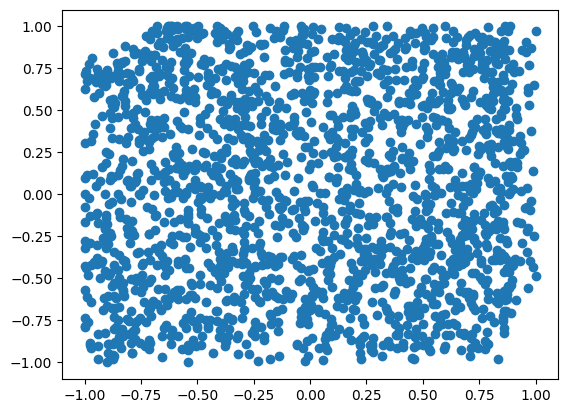

In [28]:
    
def infer_diffusion_step(net, sample_t, t):
    t_in  = torch.tensor([t]*sample_t.shape[0], dtype=torch.float32)
    
    noise = net(sample_t, t_in)
    sample_t1 = scheduler.step(noise, t, sample_t)
    return sample_t1['prev_sample']

def infer_diffusion(net, samples):
    
    denoised_samples = samples.clone()

    
    # Plot every 100 steps
    for step in range(1000):
        if step % 100==0:
            plt.figure()
            print("Step {}".format(step))
            plt.scatter(denoised_samples[:,0], denoised_samples[:, 1])
        
        denoised_samples = infer_diffusion_step(net, denoised_samples, 999 - step)
    plt.figure()
    print("Step {}".format(step))
    plt.scatter(denoised_samples[:,0], denoised_samples[:, 1])
        
with torch.no_grad():
    samples = torch.normal(torch.zeros(2000,2), std=torch.tensor(1.0))
    infer_diffusion(net, samples)